# Dynamic Definition

The Dynamic Definition algorithm allows us to sample probability distributions when storing the full-state probability is not tractable (due to memory requirements).

The algorithm as implemented in `cutqc2` has 3 parameters:
 - A function that returns a probability distribution given a `qubit_spec` - a string of *active* (`A`), *merged* (`M`) and *conditioned* (`0`/`1`) qubits. See the [merge_unmerge](merge_unmerge.ipynb) notebook for an introduction on these.
 - `capacity` - the max number of qubits we can mark as **active** at any point. This is referred to as *system memory* in Algorithm 1 of the CutQC paper.
 - `max_recursion` - the max recursions the algorithm goes through.

The algorithm is outlined below.

- Initialize empty list `probability_bins`
- **for** each DD recursion **do**
  - **if** First recursion **then**
    - Choose subset of qubits of length `capacity` to label as **active**;
  - **else**
    - Choose the bin from `probability_bins` with the largest sum of probability;
    - Fix the values of **active** qubits in the bin according to the index of the bin; Label these qubits as **zoomed**;
  - Label the rest of the qubits as **merged**;
  - For each state of the **zoomed** qubits, determine probability vectors (run *shots*, - group shots with common **merged** qubits together).
  - Reconstruct the 2<sup>active</sup> probability output for the **active** qubits; append to `probability_bins`;
  - **if** we've reached `max_recursion`, **then** return.

In effect, Dynamic Definition maintains a list of probability values (implemented using `heapq`) of active states, and at each recursion level, chooses to focus on the bin that has the highest cumulative probability mass, ignoring the rest.

Let us see it in action for a 4-qubit BV circuit. This corresponds to Figure 7 in the original CutQC paper.

### 4-qubit BV Circuit

In [1]:
import numpy as np

from cutqc2.core.dynamic_definition import DynamicDefinition
from cutqc2.core.utils import merge_prob_vector

# Emulate the probability distribution for a 4-qubit Bernstein-Vazirani problem
four_qubit_BV_probability_distribution = np.append(np.zeros(15), 1)

This circuit produces a single non-zero probability value of 1 at the bitstring index `1111`, which we emulate using `four_qubit_BV_probability_distribution`. We instantiate the `DynamicDefinition` class by providing it:
 - the total number of qubits we're emulating (`4`)
 - the `capacity` (set to `1`)
 - a handle to a function that provides it the coarse-grained probability distribution for any `qubit_spec`.

In [2]:
dynamic_definition = DynamicDefinition(
    # Bernstein-Vazirani problem with 4 qubits
    num_qubits=4,
    # We choose to have only 1 qubit active at a time
    capacity=1,
    # The probability function is a callable that takes in a "qubit spec"
    # (a string of 0/1/A/M characters), and returns the compressed quantum
    # probability vector by merging/conditioning on specific qubits.
    # The `merge_prob_vector` utility function from CutQC2 is used here.
    prob_fn=lambda qubit_spec: merge_prob_vector(
        four_qubit_BV_probability_distribution, qubit_spec
    ),
)

We then run the Dynamic Definition algorithm for increasing values of `max_recursion` to see its effects. At each recursion, we call the `dynamic_definition.plot()`, which plots the probability of every state in a merged bin as the average of the sum of probabilities for that bin.

(INFO) (dynamic_definition.py) (18-Sep-25 09:42:41) Calculating initial probabilities for qubit spec AMMM
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:41) No more bins to process or max recursion level reached.


/media/vineetb/delta/projects/cutqc2/src/cutqc2/core/dynamic_definition.py:178: UserWarning: Generating all 2^num_qubits states. This may be memory intensive.
  y = self.probabilities(full_states=full_states)


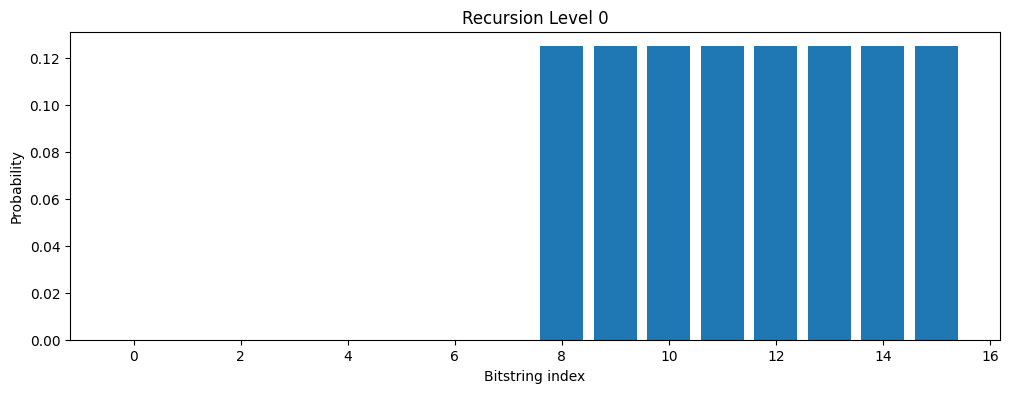

In [3]:
dynamic_definition.run(max_recursion=0)
dynamic_definition.plot()

At recursion level 0, the algorithm uses qubit_spec `AMMM`, determines the probability masses for states `0MMM` and `1MMM` as `0.0` and `1.0` respectively, and evenly distributes the probability mass of `1.0` from bin `1MMM` to all states from `1000` to `1111`.

(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) Calculating initial probabilities for qubit spec AMMM
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) recursion_level=1, qubit_spec='AMMM'
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) No more bins to process or max recursion level reached.


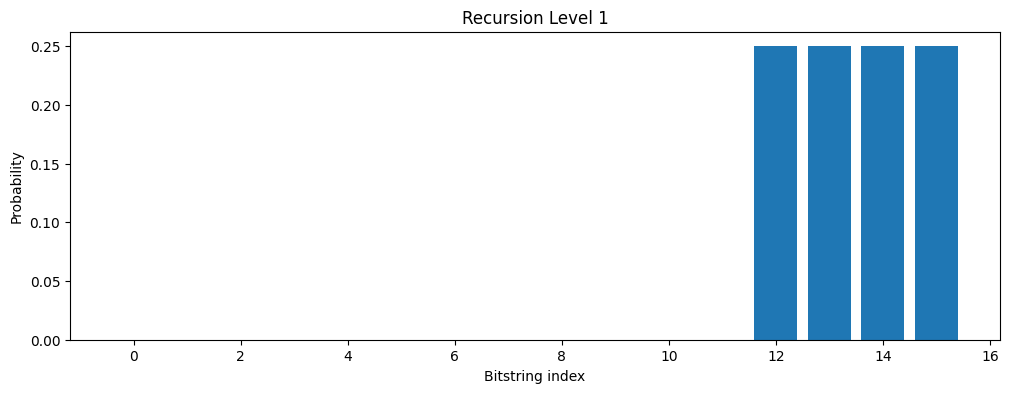

(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) Calculating initial probabilities for qubit spec AMMM
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) recursion_level=1, qubit_spec='AMMM'
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) recursion_level=2, qubit_spec='11MM'
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) No more bins to process or max recursion level reached.


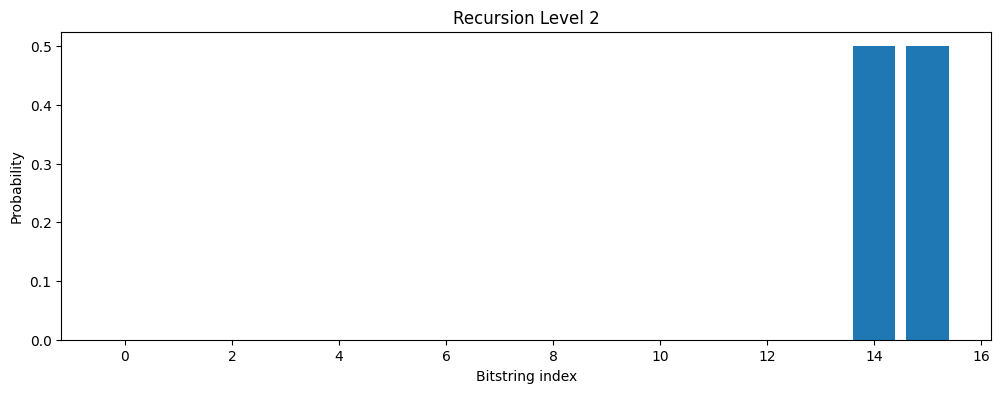

(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) Calculating initial probabilities for qubit spec AMMM
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) recursion_level=1, qubit_spec='AMMM'
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) recursion_level=2, qubit_spec='11MM'
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) recursion_level=3, qubit_spec='111M'
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) No more bins to process or max recursion level reached.


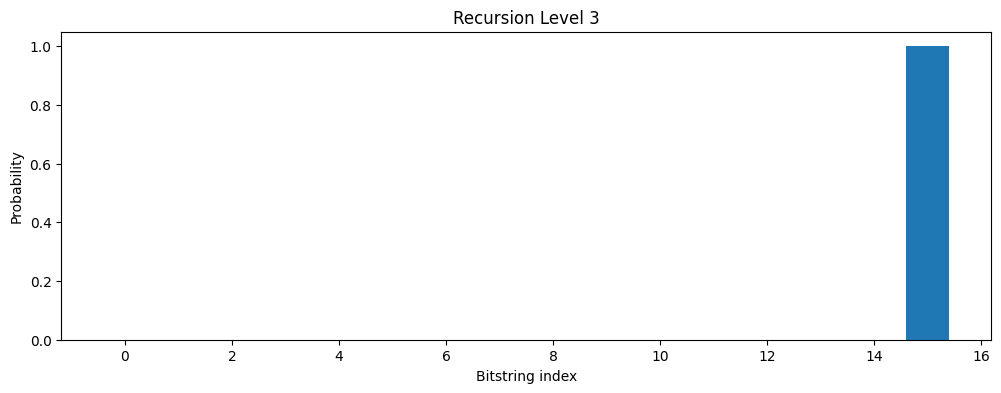

In [4]:
for max_recursion in (1, 2, 3):
    dynamic_definition.run(max_recursion=max_recursion)
    dynamic_definition.plot()

With increasing values of `max_recursion`, the algorithm is able to concentrate the probability mass (`1.0` in this case) to more and more specific states, eventually attributing all of it to the state `1111`.

### 6-qubit Supremacy Circuit

As another example, let's run Dynamic Definition on a 6-qubit Supremacy Circuit.

In [5]:
from matplotlib import pyplot as plt

from cutqc2.cutqc.helper_functions.benchmarks import generate_circ
from cutqc2.cutqc.helper_functions.non_ibmq_functions import evaluate_circ

circuit = generate_circ(
    num_qubits=6,
    depth=1,
    circuit_type="supremacy",
    reg_name="q",
    connected_only=True,
    seed=12345,
)
ground_truth = evaluate_circ(circuit, backend="statevector_simulator")


def supremacy_probability_distribution(qubit_spec: str):
    return merge_prob_vector(ground_truth, qubit_spec)

(INFO) (base_tasks.py) (18-Sep-25 09:42:42) Pass: UnrollCustomDefinitions - 0.07343 (ms)
(INFO) (base_tasks.py) (18-Sep-25 09:42:42) Pass: BasisTranslator - 0.02503 (ms)


With increasing values of `max_recursion`, the algorithm is able to approximate the ground truth probability vector better and better. `max_recursion` beyond 5 has no effect in this case, as there are no bins left to explore beyond that recursion level.

(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) Calculating initial probabilities for qubit spec AAMMMM
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) No more bins to process or max recursion level reached.
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) Calculating initial probabilities for qubit spec AAMMMM
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) recursion_level=1, qubit_spec='AAMMMM'
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) No more bins to process or max recursion level reached.
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) Calculating initial probabilities for qubit spec AAMMMM
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) recursion_level=1, qubit_spec='AAMMMM'
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) recursion_level=2, qubit_spec='1001MM'
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) No more bins to process or max recursion level reached.
(INFO) (dynamic_definition.py) (18-Sep-25 09:42:42) Calculating initial probabi

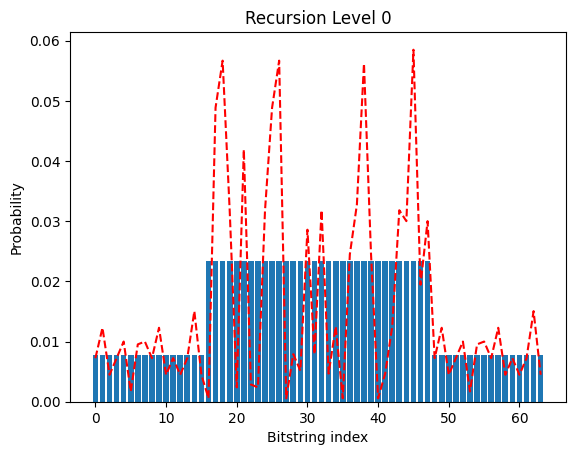

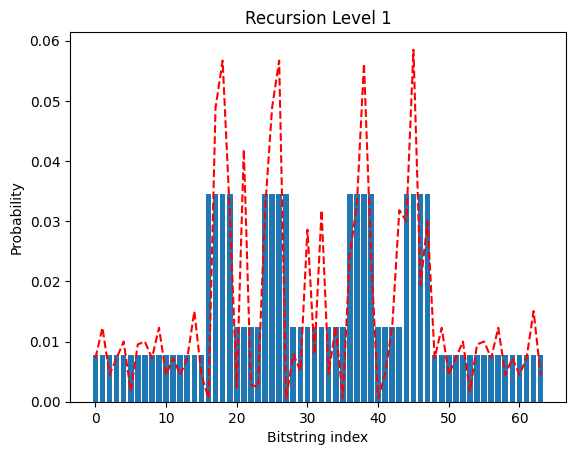

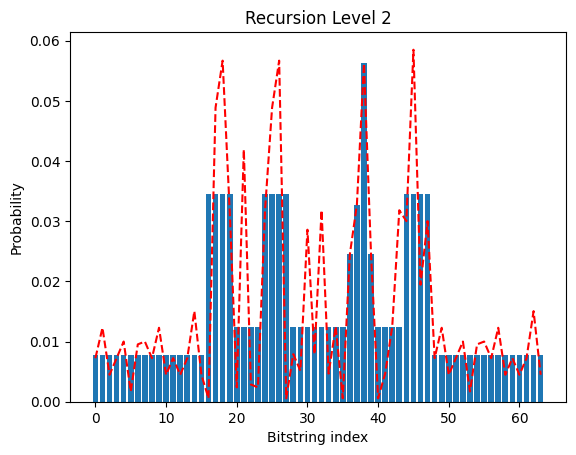

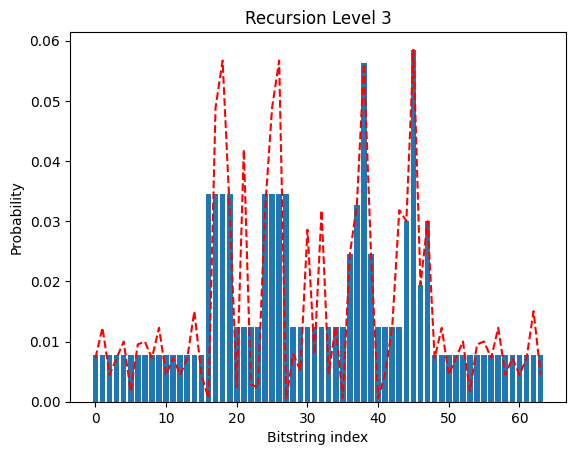

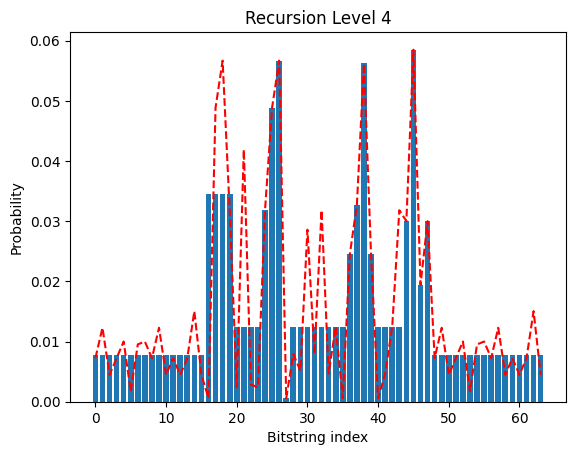

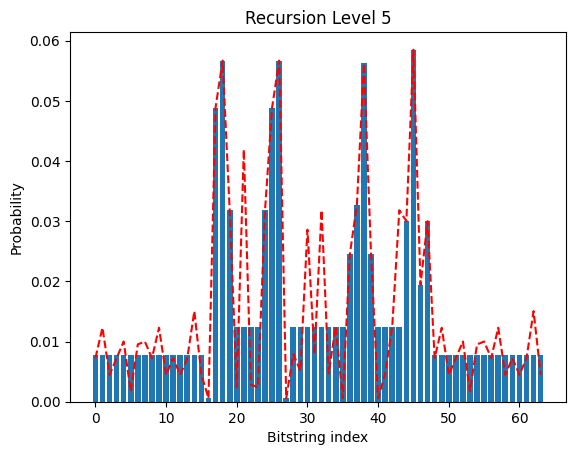

In [6]:
for max_recursion in range(6):
    fig, ax = plt.subplots()
    ax.plot(range(len(ground_truth)), ground_truth, linestyle="--", color="r")
    dynamic_definition = DynamicDefinition(
        num_qubits=6, capacity=2, prob_fn=supremacy_probability_distribution
    )
    dynamic_definition.run(max_recursion=max_recursion)
    dynamic_definition.plot(ax=ax)